<a href="https://colab.research.google.com/github/step-cheng/mnist_from_scratch/blob/main/mnist_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
import numpy as np
import time
import pandas as pd
import random
from os.path import join
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [206]:
def organize(data):
  data = np.array(data)
  np.random.shuffle(data)
  x, y = data.T[1:,:], data.T[0,:]
  return x, y

def one_hot_encode(labels):
  one_hot = np.zeros((10,labels.size))
  one_hot[labels, range(labels.size)] = 1
  return one_hot

# normalize by dividing by max value
def normalize(data):
  data = data * (1 / 255)
  return data

def split(img_data, label_data, r):
  assert img_data.shape[1] == label_data.shape[1]
  assert (img_data.shape[1] * r) % 1 == 0
  div = int(img_data.shape[1]*r)
  return img_data[:,:div], label_data[:,:div], img_data[:,div:], label_data[:,div:]


In [207]:
url1 = 'https://media.githubusercontent.com/media/step-cheng/mnist_from_scratch/main/mnist_train.csv'
url2 = 'https://media.githubusercontent.com/media/step-cheng/mnist_from_scratch/main/mnist_test.csv'
all_train = pd.read_csv(url1)
all_test = pd.read_csv(url2)

In [208]:
x_train, y_train = organize(all_train)

train_onehotY = one_hot_encode(y_train)
norm_x_train = normalize(x_train)
assert x_train.shape == (784,60000)
assert train_onehotY.shape == (10,60000)

r = 5/6
train_imgs, train_labels, val_imgs, val_labels = split(norm_x_train, train_onehotY, r)

# set up test data

x_test, y_test = organize(all_test)

test_labels = one_hot_encode(y_test)

# x_test = np.reshape(x_test, (x_test.shape[0], 784)).T
test_imgs = normalize(x_test)

assert test_imgs.shape == (784, 10000)
assert test_labels.shape == (10, 10000)

In [223]:
def show_image(img, label):
    img = np.reshape(img.T, (28,28))
    num = np.where(label == 1)
    plt.figure()
    plt.title(f'Image number: {num[0]}')
    plt.imshow(img, cmap=plt.cm.gray)


In [211]:
def initialize(dims):
  params = {}
  for i in range(1, len(dims)):
      params['W' + str(i)] = np.random.randn(dims[i], dims[i-1]) * np.sqrt(1/(dims[i]))
      params['b' + str(i)] = np.random.randn(dims[i], 1) * np.sqrt(1/dims[i])
  return params


In [212]:
def relu(Z):
  return np.maximum(Z,0)

def softmax(Z):
  Z_ = Z - np.max(Z, axis = 0, keepdims = True)
  A = np.exp(Z_) / np.sum(np.exp(Z_), axis = 0, keepdims = True)
  return A

def forward_pass(X, params):
  L = len(params)//2

  forward = {}
  forward['A0'] = X

  for i in range(1,L):
    forward['Z'+str(i)] = np.dot(params['W'+str(i)], forward['A'+str(i-1)]) + params['b'+str(i)]
    forward['A'+str(i)] = relu(forward['Z'+str(i)])

  forward['Z'+str(L)] = np.dot(params['W'+str(L)], forward['A'+str(L-1)]) + params['b'+str(L)]
  forward['A'+str(L)] = softmax(forward['Z'+str(L)])


  return forward


In [213]:
def accuracy(A, Y):
  assert A.shape == Y.shape
  pred = np.zeros_like(A)
  pred[np.argmax(A, axis = 0), range(A.shape[1])] = 1
  results = np.max(pred + Y, axis = 0) == 2

  acc = np.count_nonzero(results) / results.size
  return acc

def find_misses(A, Y):
  assert A.shape == Y.shape
  pred = np.zeros_like(A)
  pred[np.argmax(A, axis = 0), range(pred.shape[1])] = 1
  results = np.max(pred + Y, axis = 0) == 2

  miss_ind = np.where(results == False)[0].tolist()
  miss_guess = [np.argmax(pred, axis = 0)[m] for m in miss_ind]
  return miss_ind, miss_guess


In [214]:
def relu_deriv(A):
  return A > 0

def softmax_crossentropy_deriv(A, Y):
  return A - Y

def back_pass(forward, params, Y):
  L = len(params) //2

  grads = {}

  N = Y.shape[1]

  # grads['dZ'+str(L)] = 1 * softmax_crossentropy_deriv(forward['A'+str(L)], Y)
  dZ = 1 * softmax_crossentropy_deriv(forward['A'+str(L)], Y)
  # grads['dW'+str(L)] = np.dot(dZ, forward['A'+str(L-1)].T)
  grads['dW'+str(L)] = 1/N * np.dot(dZ, forward['A'+str(L-1)].T)
  assert grads['dW'+str(L)].shape == params['W'+str(L)].shape
  grads['db'+str(L)] = 1/N * np.sum(dZ, axis = 1, keepdims=True)
  assert grads['db'+str(L)].shape == params['b'+str(L)].shape


  for i in range(L-1,0,-1):
    # dA_i+1 = W_i+1.T * dZ
    # grads['dZ'+str(i)] = np.multiply(np.dot(params['W'+str(i+1)].T, grads['dZ'+str(i+1)]), relu_deriv(forward['Z'+str(i)]))
    dZ = np.dot(params['W'+str(i+1)].T, dZ) * relu_deriv(forward['Z'+str(i)])
    # grads['dW'+str(i)] = np.dot(dZ, forward['A'+str(i-1)].T)
    grads['dW'+str(i)] = 1/N * np.dot(dZ, forward['A'+str(i-1)].T)
    assert grads['dW'+str(L)].shape == params['W'+str(L)].shape
    grads['db'+str(i)] = 1/N * np.sum(dZ, axis = 1, keepdims=True)
    assert grads['db'+str(i)].shape == params['b'+str(i)].shape

  return grads


In [215]:
def learn(grads, params, rate):
  L= len(params)//2

  new_params = {}
  for i in range(1, L + 1):
    new_params['b'+str(i)] = params['b'+str(i)] - rate*grads['db'+str(i)]
    new_params['W'+str(i)] = params['W'+str(i)] - rate*grads['dW'+str(i)]

  return new_params

In [216]:
def model(img_data, label_data, num_batches, iterations = 1, rate = 0.01, dims = None, params = None, train = True):
  if params is None: params = initialize(dims)

  assert label_data.shape[1] % num_batches == 0
  batch_size = int(label_data.shape[1] / num_batches)

  L = len(params)//2
  accuracies = []
  missed_inds = []
  missed_guesses = []

  # training data
  if train:
    start = time.time()
    for i in range(1, iterations+1):
      for j in range(num_batches):
        forward = forward_pass(img_data[:,j*batch_size:(j+1)*batch_size], params)

        acc = accuracy(forward['A'+str(L)], label_data[:,j*batch_size:(j+1)*batch_size])
        accuracies.append(acc)

        grads = back_pass(forward, params, label_data[:,j*batch_size:(j+1)*batch_size])
        params = learn(grads, params, rate)

      if i % 10 == 0: print(f'Accuracy at iteration {i}: {accuracies[i-1]}')
    end = time.time()
    print(f'Training Time: {end - start} s')

  # for validating and testing data
  else:
      for j in range(num_batches):
        forward = forward_pass(img_data[:,j*batch_size:(j+1)*batch_size], params)

        acc = accuracy(forward['A'+str(L)], label_data[:,j*batch_size:(j+1)*batch_size])
        accuracies.append(acc)

        miss_ind, miss_guess = find_misses(forward['A'+str(L)], label_data[:,j*batch_size:(j+1)*batch_size])
        missed_inds += [j*batch_size + m for m in miss_ind]
        missed_guesses += [m for m in miss_guess]
        assert len(missed_inds) == len(missed_guesses)

        print(f'Accuracy at iteration {j+1}: {accuracies[j]}')

  plt.figure()
  plt.title('Training Accuracy') if train else plt.title('Test Accuracy')
  plt.xlabel('Cycles')
  plt.ylabel('accuracy (%)')
  plt.plot(range(1,len(accuracies)+1), [100*a for a in accuracies], marker = '.')
  plt.show()

  return params, missed_inds, missed_guesses

Accuracy at iteration 10: 0.47902
Accuracy at iteration 20: 0.67318
Accuracy at iteration 30: 0.74646
Accuracy at iteration 40: 0.7865
Accuracy at iteration 50: 0.81144
Accuracy at iteration 60: 0.82916
Accuracy at iteration 70: 0.8426
Accuracy at iteration 80: 0.85224
Accuracy at iteration 90: 0.86018
Accuracy at iteration 100: 0.86656
Accuracy at iteration 110: 0.87132
Accuracy at iteration 120: 0.87562
Accuracy at iteration 130: 0.8791
Accuracy at iteration 140: 0.88296
Accuracy at iteration 150: 0.88604
Accuracy at iteration 160: 0.8892
Accuracy at iteration 170: 0.89134
Accuracy at iteration 180: 0.89338
Accuracy at iteration 190: 0.89554
Accuracy at iteration 200: 0.89746
Accuracy at iteration 210: 0.8992
Accuracy at iteration 220: 0.90096
Accuracy at iteration 230: 0.90234
Accuracy at iteration 240: 0.90382
Accuracy at iteration 250: 0.9053
Accuracy at iteration 260: 0.90684
Accuracy at iteration 270: 0.90804
Accuracy at iteration 280: 0.90952
Accuracy at iteration 290: 0.91064


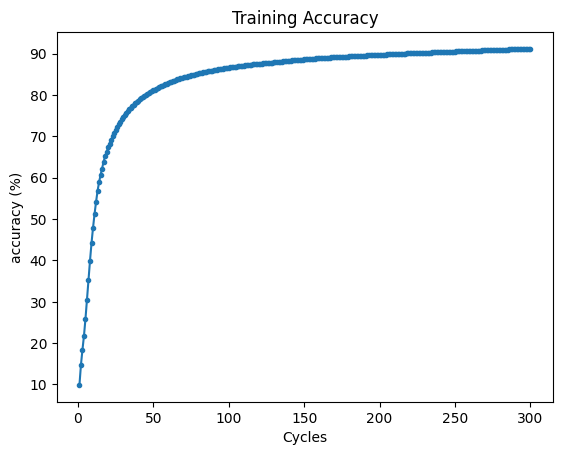

In [218]:
# train data

dimensions = [784, 128, 64, 10]
batches = 1
iterations = 300
rate = 0.05

params = model(train_imgs, train_labels, batches, iterations, rate, dimensions)[0]

Accuracy at iteration 1: 0.9095


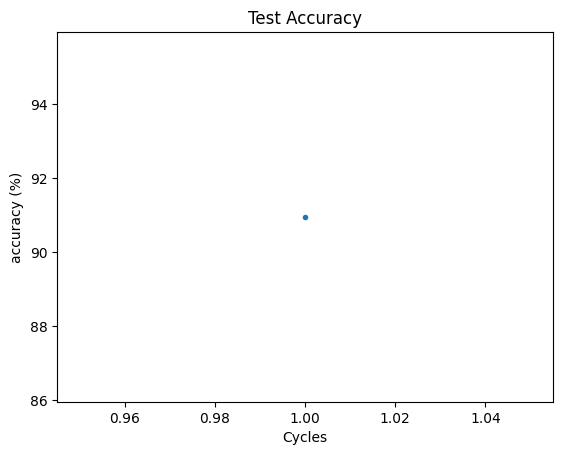

Missed 905 out of 10000


In [219]:
# validate data
batches = 1

params, val_missed_inds, val_missed_guesses = model(val_imgs, val_labels, batches, params = params, train = False)
print(f'Missed {len(val_missed_inds)} out of {val_imgs.shape[1]}')

Missed Image Index: 95; Correct value: 9


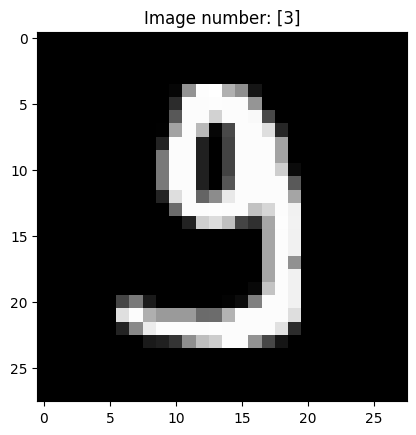

In [220]:
# Show random missed image during validation
i = random.randint(0,len(val_missed_inds))

print(f'Missed Image Index: {i}; Correct value: {np.argmax(val_labels[:,val_missed_inds[i]])}')
show_image(val_imgs[:,val_missed_inds[i]], one_hot_encode(val_missed_guesses[i]))

Accuracy at iteration 1: 0.9141


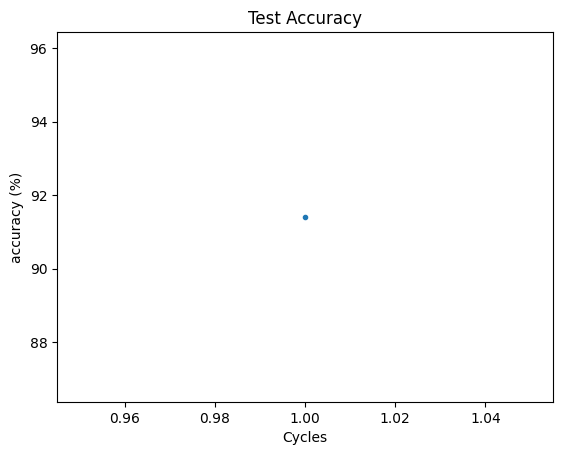

Missed 859 out of 10000


In [221]:
# test data
batches = 1

params, test_missed_inds, test_missed_guesses = model(test_imgs, test_labels, batches, params = params, train = False)
print(f'Missed {len(test_missed_inds)} out of {test_imgs.shape[1]}')

Missed Image Index: 30; Correct value: 5


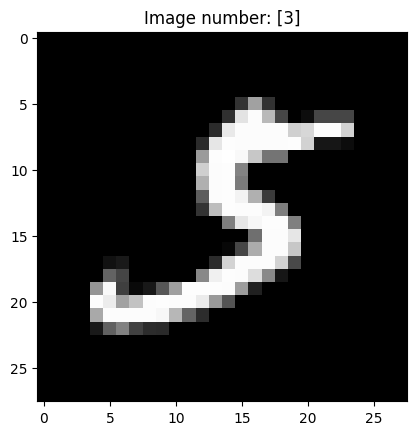

In [222]:
# Show random missed image during testing
i = random.randint(0,len(test_missed_inds))

print(f'Missed Image Index: {i}; Correct value: {np.argmax(test_labels[:,test_missed_inds[i]])}')
show_image(test_imgs[:,test_missed_inds[i]], one_hot_encode(test_missed_guesses[i]))